# using xgcm with POP output
In this notebook we will use xgcm capability to calculate divergence, vorticity and scalar gradients from high resolution (0.1$^{\circ}$) POP output.  We will

1) demonstrate the functions needed for these operations with basic ```xarray```

2) translate them to the corresponding ```xgcm``` version using ``diff`` and ``interp``. (https://xgcm.readthedocs.io/en/latest/grids.html#creating-grid-objects)

3) use ```xgcm.get_metric``` capabilities to simplify the code. (https://xgcm.readthedocs.io/en/latest/grid_metrics.html)

The ``metrics`` functionality lets us write generalized ``div``, ``grad`` and ``curl`` functions that should be available in ``xgcm`` in the future  (https://github.com/xgcm/xgcm/issues/187)

In [1]:
# import modules
import numpy as np
import xarray as xr
import xgcm
import pop_tools
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
xr.set_options(display_style="html")

## Open example dataset and modify it to work with xgcm
For the relabeling the dataset must contain ``DZU`` and ``DZT`` (they are also needed in calculations later on)

In [3]:
# open sample data
filepath = pop_tools.DATASETS.fetch('Pac_POP0.1_JRA_IAF_1993-12-6-test.nc')
ds = xr.open_dataset(filepath)

# get DZU and DZT, needed for operations later on
filepath_g = pop_tools.DATASETS.fetch('Pac_grid_pbc_1301x305x62.tx01_62l.2013-07-13.nc')
ds_g = xr.open_dataset(filepath_g)

ds["DZT"] = ds_g.DZT
ds["DZU"] = ds_g.DZU
ds["cell_volume_t"] = ds_g.DZT * ds_g.DXT * ds_g.DYT
ds["cell_volume_u"] = ds_g.DZU * ds_g.DXT * ds_g.DYT

ds contains the usual dimensions ```nlat```, ```nlon```, etc:

In [4]:
ds

<xarray.Dataset>
Dimensions:        (bnds: 2, nlat: 305, nlon: 1301, time: 1, z_t: 62)
Coordinates:
  * time           (time) object 0036-12-07 00:00:00
    TLONG          (nlat, nlon) float64 ...
    ULAT           (nlat, nlon) float64 ...
  * z_t            (z_t) float32 500.0 1500.0 2500.0 ... 562499.06 587499.06
    TLAT           (nlat, nlon) float64 ...
    ULONG          (nlat, nlon) float64 ...
Dimensions without coordinates: bnds, nlat, nlon
Data variables:
    time_bnds      (time, bnds) object ...
    UAREA          (nlat, nlon) float64 ...
    TAREA          (nlat, nlon) float64 ...
    DXU            (nlat, nlon) float64 ...
    DYU            (nlat, nlon) float64 ...
    DXT            (nlat, nlon) float64 ...
    DYT            (nlat, nlon) float64 ...
    UVEL           (time, z_t, nlat, nlon) float32 ...
    VVEL           (time, z_t, nlat, nlon) float32 ...
    TEMP           (time, z_t, nlat, nlon) float32 ...
    DZT            (z_t, nlat, nlon) float32 ...
    DZU            (z_t, nlat, nlon) float32 ...
    cell_volume_t  (z_t, nlat, nlon) float64 1.153e+15 1.153e+15 ... 2.884e+16
    cell_volume_u  (z_t, nlat, nlon) float64 1.153e+15 1.153e+15 ... 2.884e+16
Attributes:
    CDI:               Climate Data Interface version 1.9.2 (http://mpimet.mp...
    history:           Tue Mar 24 11:51:32 2020: cdo selvar,UVEL,VVEL,DXT,DXU...
    source:            CCSM POP2, the CCSM Ocean Component
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    title:             g.e20.G.TL319_t13.control.001_hfreq
    time_period_freq:  day_5
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    revision:          $Id: tavg.F90 89091 2018-04-30 15:58:32Z altuntas@ucar...
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-12-14 at 16:05:58.8
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    CDO:               Climate Data Operators version 1.9.2 (http://mpimet.mp...

We call ``pop_tools.to_xgcm_grid_dataset(ds)`` (https://pop-tools.readthedocs.io/en/latest/api.html#pop_tools.to_xgcm_grid_dataset) to make the POP dataset xgcm compatible. This means that the dimensions need to be renamed so that xgcm knows which variables are at T-points and which are at U-points.

In [5]:
grid, ds_ren = pop_tools.to_xgcm_grid_dataset(ds, periodic=False)

ds_ren contains all variables from ds, but ```nlat/nlon``` have been replaced by ```nlat_t/nlon_t``` and ```nlat_u/nlon_u``` depending on which points the variables are at:

In [6]:
ds_ren

<xarray.Dataset>
Dimensions:    (bnds: 2, nlat_t: 305, nlat_u: 305, nlon_t: 1301, nlon_u: 1301, time: 1, z_t: 62)
Coordinates:
  * time       (time) object 0036-12-07 00:00:00
    TLONG      (nlat_t, nlon_t) float64 159.9 160.0 160.1 ... 289.8 289.9 290.0
    ULAT       (nlat_u, nlon_u) float64 -15.03 -15.03 -15.03 ... 15.03 15.03
  * z_t        (z_t) float32 500.0 1500.0 2500.0 ... 562499.06 587499.06
    TLAT       (nlat_t, nlon_t) float64 -15.07 -15.07 -15.07 ... 14.98 14.98
    ULONG      (nlat_u, nlon_u) float64 160.0 160.1 160.2 ... -70.2 -70.1 -70.0
  * nlon_u     (nlon_u) int64 1 2 3 4 5 6 7 ... 1296 1297 1298 1299 1300 1301
  * nlat_u     (nlat_u) int64 1 2 3 4 5 6 7 8 ... 299 300 301 302 303 304 305
  * nlon_t     (nlon_t) float64 0.5 1.5 2.5 3.5 ... 1.298e+03 1.3e+03 1.3e+03
  * nlat_t     (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 301.5 302.5 303.5 304.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 0036-12-02 00:00:00 0036-12-07 00:00:00
    UAREA      (nlat_u, nlon_u) float64 1.153e+12 1.153e+12 ... 1.153e+12
    TAREA      (nlat_t, nlon_t) float64 1.153e+12 1.153e+12 ... 1.154e+12
    DXU        (nlat_u, nlon_u) float64 1.074e+06 1.074e+06 ... 1.074e+06
    DYU        (nlat_u, nlon_u) float64 1.074e+06 1.074e+06 ... 1.074e+06
    DXT        (nlat_t, nlon_t) float64 1.074e+06 1.074e+06 ... 1.074e+06
    DYT        (nlat_t, nlon_t) float64 1.074e+06 1.074e+06 ... 1.074e+06
    UVEL       (time, z_t, nlat_u, nlon_u) float32 -23.847055 -25.16644 ... nan
    VVEL       (time, z_t, nlat_u, nlon_u) float32 10.3000965 13.77956 ... nan
    TEMP       (time, z_t, nlat_t, nlon_t) float32 26.87082 26.860653 ... nan
    DZT        (z_t, nlat_t, nlon_t) float32 1000.0 1000.0 ... 25000.0 25000.0
    DZU        (z_t, nlat_u, nlon_u) float32 1000.0 1000.0 ... 25000.0 25000.0
Attributes:
    CDI:               Climate Data Interface version 1.9.2 (http://mpimet.mp...
    history:           Tue Mar 24 11:51:32 2020: cdo selvar,UVEL,VVEL,DXT,DXU...
    source:            CCSM POP2, the CCSM Ocean Component
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    title:             g.e20.G.TL319_t13.control.001_hfreq
    time_period_freq:  day_5
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    revision:          $Id: tavg.F90 89091 2018-04-30 15:58:32Z altuntas@ucar...
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-12-14 at 16:05:58.8
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    CDO:               Climate Data Operators version 1.9.2 (http://mpimet.mp...

`to_xgcm_grid_dataset` also created an ``xgcm.Grid`` object named ``grid`` (https://xgcm.readthedocs.io/en/latest/grids.html#creating-grid-objects). This object will make it easy to do grid-aware interpolation and differencing later on (https://xgcm.readthedocs.io/en/latest/grids.html#core-grid-operations-diff-interp-and-cumsum):

In [7]:
grid

<xgcm.Grid>
X Axis (not periodic):
  * center   nlon_t --> right
  * right    nlon_u --> center
Y Axis (not periodic):
  * center   nlat_t --> right
  * right    nlat_u --> center
T Axis (not periodic):
  * center   time
Z Axis (not periodic):
  * center   z_t

## Calculations

### 1) Divergence

#### pure xarray version

Note that the "pure xarray" functions use ``roll`` which basically uses a periodic boundary condition at the domain edges

In [8]:
# using numpy/xarray mix
def div_4pt_xr(U, V):
    """
    POP stencil operator for divergence
    using xarray 
    """
    U_at_lat_t = U + U.roll(nlat=1, roll_coords=False)  # avg U in y
    dUdx = U_at_lat_t - U_at_lat_t.roll(nlon=1, roll_coords=False)  # dU/dx
    V_at_lon_t = V + V.roll(nlon=1, roll_coords=False)  # avg V in x
    dVdy = V_at_lon_t - V_at_lon_t.roll(nlat=1, roll_coords=False)  # dV/dy
    return dUdx + dVdy


def divh_xr(U, V, dsgrid):
    """
    calulate divergence
    """
    changed_U = 0.5 * U * dsgrid.DYU * dsgrid.DZU
    changed_V = 0.5 * V * dsgrid.DXU * dsgrid.DZU
    div = div_4pt_xr(changed_U, changed_V) / (dsgrid.TAREA * dsgrid.DZT)
    return div

In [9]:
div_xr = divh_xr(ds.UVEL, ds.VVEL, ds)
div_xr

<xarray.DataArray (time: 1, z_t: 62, nlat: 305, nlon: 1301)>
array([[[[            nan,  2.82245835e-06,  6.25143603e-06, ...,
                      nan,             nan,             nan],
         [            nan, -1.80508841e-08,  8.54803433e-08, ...,
                      nan,             nan,             nan],
         [            nan,  4.01141917e-08,  1.07027005e-07, ...,
                      nan,             nan,             nan],
         ...,
         [ 1.52036280e-06, -1.44758122e-08, -3.50509592e-09, ...,
          -1.28452313e-06, -1.62644312e-06, -1.83187388e-06],
         [ 1.06668597e-06, -6.68358532e-09, -5.60290977e-08, ...,
          -5.00422545e-07, -3.13788872e-07, -1.78077049e-07],
         [-2.87810620e-06,  4.21211314e-09, -7.58155615e-08, ...,
           1.14357903e-06,  1.42170407e-06,  1.61619525e-06]],

        [[            nan,  1.74533743e-06,  5.22284492e-06, ...,
                      nan,             nan,             nan],
         [            nan,  1.08072630e-07,  2.01164913e-07, ...,
                      nan,             nan,             nan],
         [            nan,  1.64829881e-07,  2.12093400e-07, ...,
                      nan,             nan,             nan],
         ...,
         [ 2.10175014e-06, -2.46530392e-08, -1.33359923e-08, ...,
          -9.85782684e-07, -1.27092750e-06, -1.45457944e-06],
         [ 1.39484902e-06, -1.71124486e-08, -5.30453995e-08, ...,
          -3.59594038e-07, -2.12537941e-07, -1.07818230e-07],
         [-2.70882884e-06, -3.34795722e-09, -6.08791798e-08, ...,
           9.66932362e-07,  1.19484561e-06,  1.35743131e-06]],

        [[            nan,  3.15595806e-06,  7.02802573e-06, ...,
                      nan,             nan,             nan],
         [            nan,  4.57971776e-07,  4.37185407e-07, ...,
                      nan,             nan,             nan],
         [            nan,  3.95350157e-07,  1.90094040e-07, ...,
                      nan,             nan,             nan],
         ...,
         [ 2.62841089e-06, -3.95186021e-08, -2.37478182e-08, ...,
          -5.67251230e-07, -7.65181031e-07, -8.82912853e-07],
         [ 1.53577116e-06, -3.09124078e-08, -4.81920159e-08, ...,
          -1.55503431e-07, -5.99461204e-08,  8.24848154e-09],
         [-2.80308218e-06, -1.29071146e-08, -4.14695387e-08, ...,
           7.13179842e-07,  8.70195852e-07,  9.67241979e-07]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,  3.20158511e-07,             nan, ...,
                      nan,             nan,             nan],
         [            nan,  2.41920713e-07,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

     

Text(0.5, 1.0, 'xr divergence @ 55m')

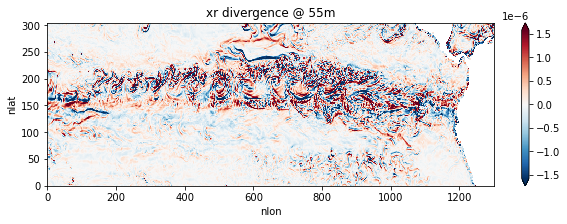

In [10]:
div_xr.isel(z_t=5, time=0).plot(robust=True, figsize=(10, 3))
plt.title("xr divergence @ {:d}m".format(int(div_xr.z_t.isel(z_t=5).values / 100)))

#### minimal xgcm version

Instead of using xarray's ``roll``, we can use xgcm's ``interp`` and ``diff``:

In [11]:
# using xgcm
def div_4pt_xgcm(U, V):  # Basic stencil operator for B-grid divergence
    """
    POP stencil operator for divergence
    using xgcm 
    """
    U_at_lat_t = grid.interp(
        U, axis="Y", boundary="extend"
    )  # array - array.roll becomes interp
    # -> this incoorporates the * 0.5
    dUdx = grid.diff(U_at_lat_t, axis="X", boundary="extend")  # - becomes diff
    V_at_lon_t = grid.interp(V, axis="X", boundary="extend")
    dVdy = grid.diff(V_at_lon_t, axis="Y", boundary="extend")
    div_4pt = dUdx + dVdy
    return div_4pt


def divh_xgcm(U, V, ds_grid):  # Divergence of horizontal velocity. Result on T-grid
    """
    calulate divergence with xgcm
    """
    changed_U = U * ds_grid.DYU * ds_grid.DZU
    changed_V = V * ds_grid.DXU * ds_grid.DZU
    divh = div_4pt_xgcm(changed_U, changed_V) / (ds_grid.TAREA * ds_grid.DZT)
    return divh

In [12]:
div_xgcm = divh_xgcm(ds_ren.UVEL, ds_ren.VVEL, ds_ren)
div_xgcm

<xarray.DataArray (time: 1, z_t: 62, nlat_t: 305, nlon_t: 1301)>
array([[[[ 0.00000000e+00, -1.22930843e-06, -3.79666626e-08, ...,
                      nan,             nan,             nan],
         [ 1.29710470e-06, -1.80508841e-08,  8.54803433e-08, ...,
                      nan,             nan,             nan],
         [ 4.90406732e-07,  4.01141917e-08,  1.07027005e-07, ...,
                      nan,             nan,             nan],
         ...,
         [ 1.55323600e-07, -1.44758122e-08, -3.50509592e-09, ...,
          -1.28452313e-06, -1.62644312e-06, -1.83187388e-06],
         [ 1.10498548e-07, -6.68358532e-09, -5.60290977e-08, ...,
          -5.00422545e-07, -3.13788872e-07, -1.78077049e-07],
         [ 1.59686076e-07,  4.21211314e-09, -7.58155615e-08, ...,
           1.14357903e-06,  1.42170407e-06,  1.61619525e-06]],

        [[ 0.00000000e+00, -1.14137591e-06,  3.27276755e-08, ...,
                      nan,             nan,             nan],
         [ 1.33188653e-06,  1.08072630e-07,  2.01164913e-07, ...,
                      nan,             nan,             nan],
         [ 5.30723976e-07,  1.64829881e-07,  2.12093400e-07, ...,
                      nan,             nan,             nan],
         ...,
         [ 1.47995715e-07, -2.46530392e-08, -1.33359923e-08, ...,
          -9.85782684e-07, -1.27092750e-06, -1.45457944e-06],
         [ 1.10673318e-07, -1.71124486e-08, -5.30453995e-08, ...,
          -3.59594038e-07, -2.12537941e-07, -1.07818230e-07],
         [ 1.65257991e-07, -3.34795722e-09, -6.08791798e-08, ...,
           9.66932362e-07,  1.19484561e-06,  1.35743131e-06]],

        [[ 0.00000000e+00, -1.10059871e-06, -8.66618753e-08, ...,
                      nan,             nan,             nan],
         [ 1.62196580e-06,  4.57971776e-07,  4.37185407e-07, ...,
                      nan,             nan,             nan],
         [ 8.38967331e-07,  3.95350157e-07,  1.90094040e-07, ...,
                      nan,             nan,             nan],
         ...,
         [ 1.39412599e-07, -3.95186021e-08, -2.37478182e-08, ...,
          -5.67251230e-07, -7.65181031e-07, -8.82912853e-07],
         [ 1.14498890e-07, -3.09124078e-08, -4.81920159e-08, ...,
          -1.55503431e-07, -5.99461204e-08,  8.24848154e-09],
         [ 1.77094567e-07, -1.29071146e-08, -4.14695387e-08, ...,
           7.13179842e-07,  8.70195852e-07,  9.67241979e-07]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [ 0.00000000e+00,             nan,             nan, ...,
                      nan,             nan,             nan],
         [ 4.61551290e-07,  3.20158511e-07,             nan, ...,
                      nan,             nan,             nan],
         [ 3.96120835e-07,  2.41920713e-07,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

 

Text(0.5, 1.0, 'xgcm divergence @ 55m')

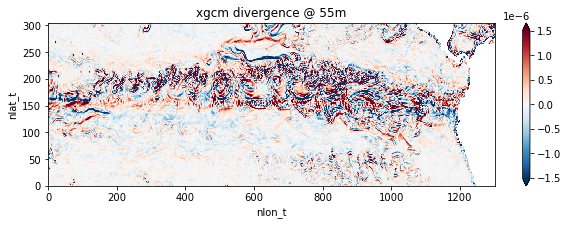

In [13]:
div_xgcm.isel(z_t=5, time=0).plot(robust=True, figsize=(10, 3))
plt.title("xgcm divergence @ {:d}m".format(int(div_xgcm.z_t.isel(z_t=5).values / 100)))

In [14]:
#  this is the same except for boundary points because the pure xarray version assumes that the boundaries are periodic
xr.testing.assert_equal(
    (
        div_xgcm.rename({"nlon_t": "nlon", "nlat_t": "nlat"})  # rename dimensions back to nlon, nlat
        .assign_coords(nlat=div_xr.nlat, nlon=div_xr.nlon)
        .reset_coords(drop=True)
        .isel(nlon=slice(1, -1), nlat=slice(1, -1))
    ),
    (
        div_xr.assign_coords(nlat=div_xr.nlat, nlon=div_xr.nlon)
        .reset_coords(drop=True)
        .isel(nlon=slice(1, -1), nlat=slice(1, -1))
    ),
)

#### xgcm with metrics

If we create an ``xgcm.Grid`` object with the ``metrics`` term specified, the code can be substantially simplified.

For the metric capabilities we will use later on we need to define metrics for pop (this could be moved to ``pop_tools`` for convenience so that ``grid`` is always created with ``metrics`` information). 

``metrics`` is a dictionary that maps axes names (one of ``X, Y, Z``) to distances along that axis

In [15]:
#pop_tools should handle this bit in the future
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],  # areas, technically not needed
}

In [16]:
# xgcm metrics
gridm, xdsm = pop_tools.to_xgcm_grid_dataset(ds, periodic=False, metrics=metrics)

 Note that the code below does not explicitly use ``DZT`` or ``DZU``.

In [17]:
def div_stencil(U, V, grid):  # Basic stencil operator for B-grid divergence
    """
    stencil operator for divergence
    using xgcm.metrics on pop
    """
    U = grid.interp(U, axis="Y", boundary="extend")
    V = grid.interp(V, axis="X", boundary="extend")
    dUdx = grid.diff(U, axis="X", boundary="extend")
    dVdy = grid.diff(V, axis="Y", boundary="extend")
    div_4pt = dUdx + dVdy
    return div_4pt


def x_divh(U, V, grid, boundary=None):
    """
    horizontal divergence
    with xgcm.get_metrics
    """
    dy = grid.get_metric(U, "Y")
    dx = grid.get_metric(V, "X")
    dz = grid.get_metric(U, "Z")
    UT = U * dy * dz
    VT = V * dx * dz
    div = div_stencil(UT, VT, grid)
    volume = grid.get_metric(div, "XYZ")
    div = div / volume

    return div


div_xgcm_m = x_divh(xdsm.UVEL, xdsm.VVEL, gridm)
div_xgcm_m

<xarray.DataArray (time: 1, z_t: 62, nlat_t: 305, nlon_t: 1301)>
array([[[[ 0.00000000e+00, -1.22930843e-06, -3.79666626e-08, ...,
                      nan,             nan,             nan],
         [ 1.29710470e-06, -1.80508841e-08,  8.54803433e-08, ...,
                      nan,             nan,             nan],
         [ 4.90406732e-07,  4.01141917e-08,  1.07027005e-07, ...,
                      nan,             nan,             nan],
         ...,
         [ 1.55323600e-07, -1.44758122e-08, -3.50509592e-09, ...,
          -1.28452313e-06, -1.62644312e-06, -1.83187388e-06],
         [ 1.10498548e-07, -6.68358532e-09, -5.60290977e-08, ...,
          -5.00422545e-07, -3.13788872e-07, -1.78077049e-07],
         [ 1.59686076e-07,  4.21211314e-09, -7.58155615e-08, ...,
           1.14357903e-06,  1.42170407e-06,  1.61619525e-06]],

        [[ 0.00000000e+00, -1.14137591e-06,  3.27276755e-08, ...,
                      nan,             nan,             nan],
         [ 1.33188653e-06,  1.08072630e-07,  2.01164913e-07, ...,
                      nan,             nan,             nan],
         [ 5.30723976e-07,  1.64829881e-07,  2.12093400e-07, ...,
                      nan,             nan,             nan],
         ...,
         [ 1.47995715e-07, -2.46530392e-08, -1.33359923e-08, ...,
          -9.85782684e-07, -1.27092750e-06, -1.45457944e-06],
         [ 1.10673318e-07, -1.71124486e-08, -5.30453995e-08, ...,
          -3.59594038e-07, -2.12537941e-07, -1.07818230e-07],
         [ 1.65257991e-07, -3.34795722e-09, -6.08791798e-08, ...,
           9.66932362e-07,  1.19484561e-06,  1.35743131e-06]],

        [[ 0.00000000e+00, -1.10059871e-06, -8.66618753e-08, ...,
                      nan,             nan,             nan],
         [ 1.62196580e-06,  4.57971776e-07,  4.37185407e-07, ...,
                      nan,             nan,             nan],
         [ 8.38967331e-07,  3.95350157e-07,  1.90094040e-07, ...,
                      nan,             nan,             nan],
         ...,
         [ 1.39412599e-07, -3.95186021e-08, -2.37478182e-08, ...,
          -5.67251230e-07, -7.65181031e-07, -8.82912853e-07],
         [ 1.14498890e-07, -3.09124078e-08, -4.81920159e-08, ...,
          -1.55503431e-07, -5.99461204e-08,  8.24848154e-09],
         [ 1.77094567e-07, -1.29071146e-08, -4.14695387e-08, ...,
           7.13179842e-07,  8.70195852e-07,  9.67241979e-07]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [ 0.00000000e+00,             nan,             nan, ...,
                      nan,             nan,             nan],
         [ 4.61551290e-07,  3.20158511e-07,             nan, ...,
                      nan,             nan,             nan],
         [ 3.96120835e-07,  2.41920713e-07,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

 

This works as follows: ``grid.get_metric(U, "Y")`` tells ``xgcm`` to find a ``DY`` variable that is at U-points. 

``xgcm`` checks ``DYU`` and ``DYT`` (both specified as Y-distances in ``metrics``) and chooses ``DYU`` because ``DYU.dims = (nlat_u, nlon_u)`` matches ``U.dims = ("time", "z_t", "nlat_u", "nlon_u")``

In [18]:
print(xdsm.DYU.dims)
print(xdsm.UVEL.dims)

('nlat_u', 'nlon_u')
('time', 'z_t', 'nlat_u', 'nlon_u')


In [19]:
xr.testing.assert_equal(
    gridm.get_metric(xdsm.UVEL, "Y"), xdsm.DYU.reset_coords(drop=True),
)

Text(0.5, 1.0, 'xgcm_metric divergence @ 55m')

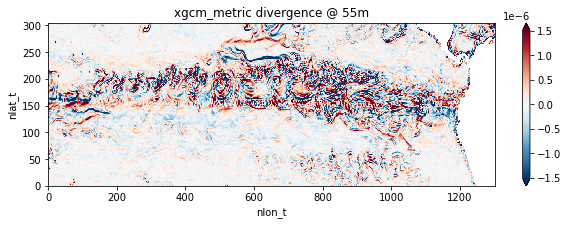

In [20]:
div_xgcm_m.isel(z_t=5, time=0).plot(robust=True, figsize=(10, 3))
plt.title(
    "xgcm_metric divergence @ {:d}m".format(
        int(div_xgcm_m.z_t.isel(z_t=5).values / 100)
    )
)

Text(0.5, 1.0, 'xgcm metrics')

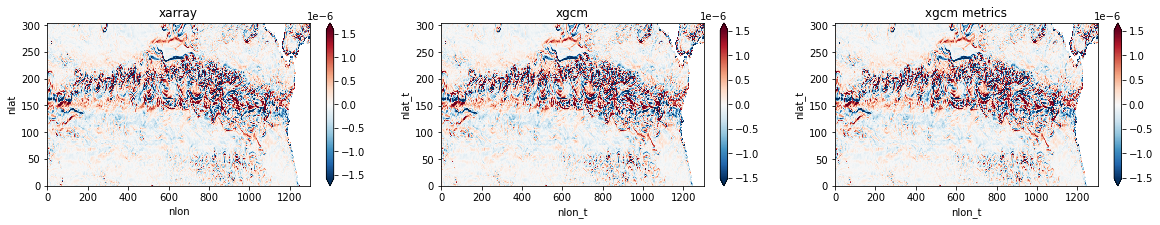

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
div_xr.isel(z_t=5, time=0).plot(ax=ax[0], robust=True)
ax[0].set_title("xarray")
div_xgcm.isel(z_t=5, time=0).plot(ax=ax[1], robust=True)
ax[1].set_title("xgcm")
div_xgcm_m.isel(z_t=5, time=0).plot(ax=ax[2], robust=True)
ax[2].set_title("xgcm metrics")

The two xgcm versions agree in the treatment of boundaries, whereas xarray assumes periodic boundaries so that the boundary values differ (the rest are the same):

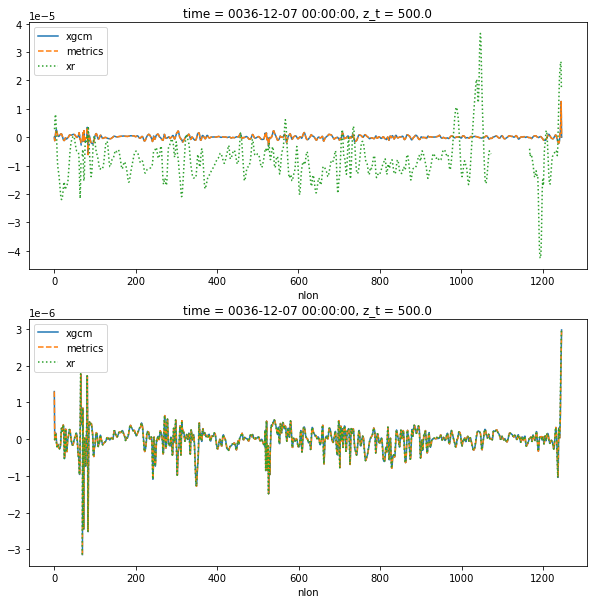

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
div_xgcm.isel(nlat_t=0, z_t=0).plot(label="xgcm", ax=ax[0])
div_xgcm_m.isel(nlat_t=0, z_t=0).plot(ls="--", label="metrics", ax=ax[0])
div_xr.isel(nlat=0, z_t=0).plot(label="xr", ax=ax[0], ls=':')
ax[0].legend()

div_xgcm.isel(nlat_t=1, z_t=0).plot(label="xgcm", ax=ax[1])
div_xgcm_m.isel(nlat_t=1, z_t=0).plot(ls="--", label="metrics", ax=ax[1])
div_xr.isel(nlat=1, z_t=0).plot(label="xr", ax=ax[1], ls=':')
ax[1].legend()

In [23]:
# the two xgcm versions are the same
xr.testing.assert_equal(div_xgcm.drop(["TLONG", "TLAT"]), div_xgcm_m)

### 2) Curl

In [ ]:
# define different functions for curl
def z_curl_xr(U, V, ds_grid):
    """
    xr based
    """
    vdy = 0.5 * V * ds.DYU
    udx = -0.5 * U * ds.DXU
    zcurl = div_4pt_xr(vdy, udx) / ds.TAREA
    return zcurl


def z_curl_xgcm(U, V, ds_grid):
    """
    xgcm based
    """
    WORKX = V * ds_grid.DYU
    WORKY = -U * ds_grid.DXU
    zcurl = div_4pt_xgcm(WORKX, WORKY) / ds_grid.TAREA
    return zcurl


def x_curlz(U, V, grid):
    """
    xgcm based using metrics
    """
    Udx = U * grid.get_metric(U, "X")
    Vdy = V * grid.get_metric(V, "Y")
    der = div_stencil(Vdy, -Udx, grid)
    area = grid.get_metric(der, "XY")
    curlz = der / area
    return curlz

In [24]:
xr_zcurl = z_curl_xr(ds.UVEL, ds.VVEL, ds)
xgcm_zcurl = z_curl_xgcm(ds_ren.UVEL, ds_ren.VVEL, ds_ren)
xgcm_m_zcurl = x_curlz(ds_ren.UVEL, ds_ren.VVEL, gridm)

Text(0.5, 1.0, 'xgcm metrics')

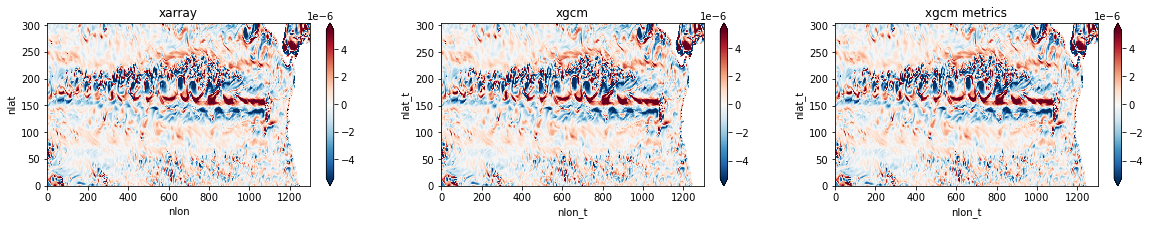

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
xr_zcurl.isel(z_t=5, time=0).plot(ax=ax[0], robust=True)
ax[0].set_title("xarray")
xgcm_zcurl.isel(z_t=5, time=0).plot(ax=ax[1], robust=True)
ax[1].set_title("xgcm")
xgcm_m_zcurl.isel(z_t=5, time=0).plot(ax=ax[2], robust=True)
ax[2].set_title("xgcm metrics")

In [26]:
# test xgcm versions:
xr.testing.assert_equal(xgcm_zcurl.drop(["TLONG", "TLAT"]), xgcm_m_zcurl)

In [27]:
# test xarray vs xgcm version:
xr.testing.assert_equal(
    (xr_zcurl
     .drop(["TLONG", "TLAT","ULONG", "ULAT"])
     .assign_coords(nlat=div_xr.nlat, nlon=div_xr.nlon)
     .reset_coords(drop=True)
    .isel(nlon=slice(1,-1), nlat=slice(1,-1)))
,
    (xgcm_zcurl
     .rename({"nlon_t": "nlon", "nlat_t": "nlat"}) 
     .assign_coords(nlat=div_xr.nlat, nlon=div_xr.nlon)
     .reset_coords(drop=True)
    .isel(nlon=slice(1,-1), nlat=slice(1,-1)))
)

### 3) Gradient

In [28]:
# define different functions

# xarray
def grad_4pt_xr(F):
    """
    gradient stencil using xarray
    """
    WORK2 = F.roll(nlat=-1, roll_coords=False)          # F[i,j+1]
    WORK1 = WORK2.roll(nlon=-1, roll_coords=False) - F  # F[i+1,j+1] - F[i,j]
    WORK2 = WORK2 - F.roll(nlon=-1, roll_coords=False)  # F[i,j+1] - F[i+1,j]
    GX = WORK1 - WORK2
    GY = WORK1 + WORK2
    return GX, GY


def gradh_xr(F, DX, DY):
    """
    gradient calculation
    """
    GX, GY = grad_4pt_xr(F)
    GX = 0.5 * GX / DX
    GY = 0.5 * GY / DY
    return GX, GY


# xgcm
def grad_4pt_xgcm(F):  # Basic stencil operator for B-grid gradient (e.g. for pressure)
    """
    gradient stencil with xgcm
    """
    F_at_lat_u = grid.interp(F, axis="Y", boundary="extend")  # 0.5*(F[i,j+1]+F[i,j])
    dFdx = grid.diff(F_at_lat_u, axis="X", boundary="extend")
    F_at_lon_u = grid.interp(F, axis="X", boundary="extend")  # 0.5*(F[i+1,j]+F[i,j])
    dFdy = grid.diff(F_at_lon_u, axis="Y", boundary="extend")
    return dFdx, dFdy


def gradh_xgcm(F, ds_grid):  # Gradient of scalar. Result on U-grid
    """
    gradient of scalar 
    """
    GX, GY = grad_4pt_xgcm(F)
    GX = GX / ds_grid.DXU
    GY = GY / ds_grid.DYU
    return GX, GY


# xgcm_metrics -> this becomes really easy!
def x_gradh(F, grid):
    """
    gradient of scalar xgcm_metrics
    for pop 
    """
    F_yi = grid.interp(F, axis="Y", boundary="extend")  # 0.5*(F[i,j+1]+F[i,j])
    F_xi = grid.interp(F, axis="X", boundary="extend")  # 0.5*(F[i+1,j]+F[i,j])
    dFdx = grid.derivative(F_yi, axis="X", boundary="extend")
    dFdy = grid.derivative(F_xi, axis="Y", boundary="extend")
    return dFdx, dFdy

In [29]:
# test different versions
GX_x, GY_x = gradh_xr(ds.TEMP, ds.DXT, ds.DYU)      # xarray version
GX_xgcm, GY_xgcm = gradh_xgcm(ds_ren.TEMP, ds_ren)  # xgcm version
GX_xgcm_m, GY_xgcm_m = x_gradh(ds_ren.TEMP, gridm)  # xgcm metrics version

Text(0.5, 1.0, '')

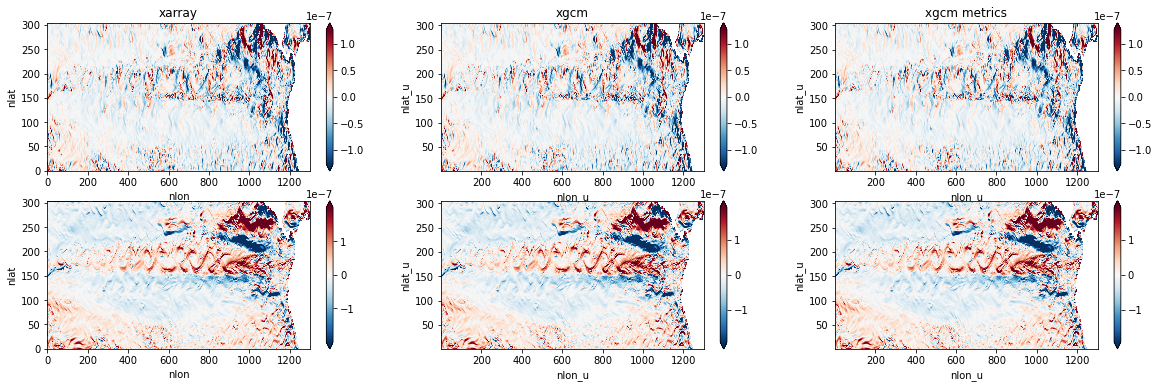

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(20, 6))
GX_x.isel(z_t=5, time=0).plot(ax=ax[0, 0], robust=True)
ax[0, 0].set_title("xarray")
GX_xgcm.isel(z_t=5, time=0).plot(ax=ax[0, 1], robust=True)
ax[0, 1].set_title("xgcm")
GX_xgcm_m.isel(z_t=5, time=0).plot(ax=ax[0, 2], robust=True)
ax[0, 2].set_title("xgcm metrics")

GY_x.isel(z_t=5, time=0).plot(ax=ax[1, 0], robust=True)
ax[1, 0].set_title("")
GY_xgcm.isel(z_t=5, time=0).plot(ax=ax[1, 1], robust=True)
ax[1, 1].set_title("")
GY_xgcm_m.isel(z_t=5, time=0).plot(ax=ax[1, 2], robust=True)
ax[1, 2].set_title("")

In [31]:
# testing xgcm version:
xr.testing.assert_equal(GX_xgcm_m, GX_xgcm.drop(["ULONG", "ULAT"]))

In [32]:
# testing xarray version xgcm version:
xr.testing.assert_allclose(
    (GX_x
     .drop(["TLONG", "TLAT","ULONG", "ULAT"])
     .assign_coords(nlat=div_xr.nlat, nlon=div_xr.nlon)
     .reset_coords(drop=True)
    .isel(nlon=slice(1,-1), nlat=slice(1,-1)))
,
    (GX_xgcm_m
     .rename({"nlon_u": "nlon", "nlat_u": "nlat"}) 
     .assign_coords(nlat=div_xr.nlat, nlon=div_xr.nlon)
     .reset_coords(drop=True)
    .isel(nlon=slice(1,-1), nlat=slice(1,-1)))
)